# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

## Imports

In [55]:
import h5py 
import mat73
import numpy as np
import mne
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import ttest_1samp

## Load File Paths

In [3]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
ncsl_share = '/mnt/ncsl_share'
data_path = ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject06_snapshot_normalized.npy'
setup_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Setup.mat'
raw_path = ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT06/EFRI06_WAR_SES1_Raw.mat'
out_path_tvalues = f't_values'

raw_file = h5py.File(raw_path)
setup_data = mat73.loadmat(setup_path)

In [ ]:
setup_data['filters'].keys()

## Instantiate variables

In [4]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [5]:
data = np.load(data_path)
num_trials, num_channels, num_freqs, num_timesteps = data.shape

In [6]:
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Model Training

Using the power per wavelet scale for a particular channel and timepoint as a feature. 

In [108]:
def train_LDA_model(data, y, channel, time):
    X = data[:, channel, :, time] # get the EEG data for a particular channel and time point

    estimators = []
    scores = []

    # 5 fold cross validation repeated 10 times
    rkf = RepeatedKFold(n_splits=5, n_repeats=1)

    for train, test in rkf.split(X):
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        lda.fit(X[train], y[train])
        estimators.append(lda)
        scores.append(lda.score(X[test], y[test]))
    
    best_score = max(scores)
    best_index = list(scores).index(best_score) 
    best_lda = estimators[best_index] # select the best performing model after cross-validation
    
    dval = np.dot(X, best_lda.coef_.T) + best_lda.intercept_ # calcualte decision value 
    
    t_stat = ttest_1samp(dval, popmean=0).statistic # perform 1-sided t-test on decision values corresponding to high bet
    return best_score, dval[:,0], t_stat[0]

In [109]:
dvals = np.zeros((num_channels, num_timesteps, num_trials))
t_stats = np.zeros((num_channels,num_timesteps))
best_scores = np.zeros((num_channels, num_timesteps))

for channel in range(num_channels):
    for time in range(num_timesteps):
        best_scores[channel, time], dvals[channel, time], t_stats[channel,time] = train_LDA_model(data, y, channel, time)

In [114]:
best_scores[0]

array([0.7027027 , 0.62162162, 0.54054054, 0.64864865, 0.7027027 ,
       0.72972973, 0.7027027 , 0.62162162, 0.72972973, 0.56756757,
       0.62162162, 0.59459459, 0.56756757, 0.64864865, 0.67567568,
       0.62162162, 0.59459459, 0.62162162, 0.64864865, 0.56756757,
       0.59459459, 0.56756757, 0.54054054, 0.67567568, 0.67567568,
       0.56756757, 0.64864865, 0.56756757, 0.56756757, 0.59459459,
       0.62162162, 0.62162162, 0.62162162, 0.64864865, 0.62162162,
       0.67567568, 0.54054054, 0.62162162, 0.67567568, 0.67567568,
       0.64864865, 0.67567568, 0.78378378, 0.56756757, 0.62162162,
       0.67567568, 0.56756757, 0.62162162, 0.72972973, 0.7027027 ,
       0.56756757, 0.59459459, 0.67567568, 0.62162162, 0.54054054,
       0.59459459, 0.75675676, 0.62162162, 0.62162162, 0.64864865,
       0.72972973, 0.62162162, 0.64864865, 0.59459459, 0.7027027 ,
       0.62162162, 0.62162162, 0.62162162, 0.67567568, 0.62162162,
       0.67567568, 0.56756757, 0.59459459, 0.67567568, 0.67567

## Reshuffling of Data

In [8]:
def shuffle_y(y):
    # Get the locations for each particualr card value
    card_value_indices = []
    for i in [2,4,6,8,10]:
        card_value_indices.append(np.where(subject_cards == i)[0])

    y_shuffled = np.zeros(y.shape)

    # Ensure that the number of high bets in the shuffled y labels is consistent with the card value
    for indices in card_value_indices:
        temp = indices
        num_high_bets = y[indices].sum() + round(np.random.uniform(-1,1)*y[indices].sum()*0.2) # Get the number of high bets for a particular card value and add some randomness to it
        for j in range(num_high_bets):
            if np.any(temp):
                # Pick a random location from all possible locations of that particular card value and set it to 1 (ie high bet)
                rand = np.random.choice(temp)
                y_shuffled[rand] = 1
                rand_index = np.where(temp == rand)[0]
                temp = np.delete(temp,rand_index) # Remove that location from being able to be chosen again
        y_shuffled[temp] = 0 # set all other locations for that particular card value to 0 (ie low bet)

    return y_shuffled

## Multiprocessing

In [78]:
def get_shuffled_t_values(data, y, num_channels, num_timesteps, num_trials):
    np.random.seed()
    dvals = np.zeros((num_channels, num_timesteps, num_trials))
    t_stats = np.zeros((num_channels,num_timesteps))
    best_scores = np.zeros(num_channels, num_timesteps)
    y_shuffled = shuffle_y(y)
    
    for channel in range(num_channels):
       for time in range(num_timesteps):
          best_scores[channel,time], dvals[channel,time], t_stats[channel,time] = train_LDA_model(data, y_shuffled, channel, time)
    
    return t_stats

In [ ]:
import multiprocessing

n_processes = 2
pool = multiprocessing.Pool(processes= n_processes)
results = pool.starmap(get_shuffled_t_values, [(data, y, num_channels, num_timesteps, num_trials)] * 1)
pool.close()

In [10]:
sub6_shuffled_t_stats = np.load('t_values/Subject06_shuffled_tvalues.npy')

In [11]:
sub6_shuffled_t_stats.shape

(100, 133, 100)

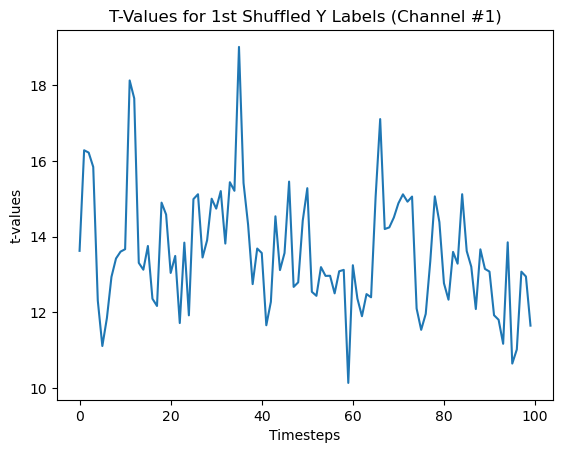

In [12]:
plt.plot(sub6_shuffled_t_stats[0][0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for 1st Shuffled Y Labels (Channel #1)')
plt.show()

In [13]:
sub6_t_stats = np.load('t_values/Subject06_tvalues.npy')

In [11]:
sub6_t_stats.shape

(133, 100)

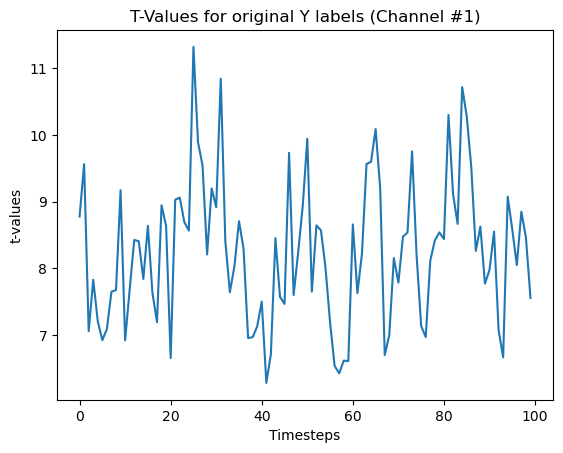

In [15]:
plt.plot(sub6_t_stats[0])
plt.xlabel('Timesteps')
plt.ylabel('t-values')
plt.title('T-Values for original Y labels (Channel #1)')
plt.show()

In [ ]:
import itertools
from joblib import Parallel, delayed


t_values = Parallel(n_jobs=-1)(delayed(get_shuffled_t_values) for i in range(1))

In [ ]:
from multiprocessing import Pool
import itertools

if __name__ == '__main__':
    pool = Pool(processes=24)
    results_ = []
    result = pool.map(shuffle_y, [y]*100)
    results_.append(result)
    pool.close()
    pool.join()

# Visualization of the Accuracy of the Models

In [116]:
# mean_accuracies = np.mean(model_accuracies, axis=(2)) # Create an array storing the average accuracies for each channel at each timepoint
best_scores_max = np.zeros((num_channels,2))

for channel in range(num_channels):
    best_scores_max[channel, 1] = max(best_scores[channel,:]) # value of the max score in a particular channel
    best_scores_max[channel, 0] = list(best_scores[channel]).index(best_scores_max[channel, 1]) # the time point at which the maximum accuracy occurs

sorted_best_scores_max = np.sort(best_scores_max)

<function matplotlib.pyplot.show(close=None, block=None)>

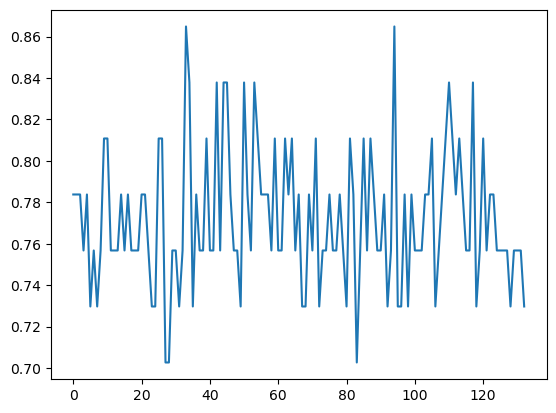

In [118]:
plt.plot(sorted_best_scores_max[:,0])
plt.show

In [ ]:
print(np.argsort(mean_accuracies_max[:,0]))
print(top_ten_accuracies_index)
print(mean_accuracies_max[top_ten_accuracies_index])

In [ ]:
plt.plot(best_scores_max[:, 0])

In [ ]:
# Plot the mean accuracy vs time graph of the top 10 channels with the highest accuracy

fig, axs = plt.subplots(10, 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(top_ten_accuracies_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')
    ax.axvspan(mean_accuracies_max[channel,1],mean_accuracies_max[channel,1]+.1,color = 'red', alpha=0.5)
    # ax.annotate('local max', xy=(40, .5))
    ax.annotate(f'(Time: {mean_accuracies_max[channel,1]:.0f}, Accuracy: {mean_accuracies_max[channel,0]:.2f})', xy=(mean_accuracies_max[channel,1] + 1,.5))

plt.savefig('top_ten_accuracies.png')
plt.show()

In [ ]:
plt.savefig('top_ten_accuracies.png')

## Covariance matrices

In [ ]:
import seaborn as sns

cov = np.cov(mean_accuracies)
sns.heatmap(cov)

In [ ]:
cov_max = np.zeros((num_channels,2))
cov_diag = np.zeros((num_channels))

for channel in range(num_channels):
    # cov_max[channel] = cov[channel].max() # Used to sanity check that cov_diag == cov_max
    cov_temp = cov[channel, np.arange(num_channels) != channel] # Get the entire row 
    cov_max[channel,0] = cov_temp.max()
    cov_max[channel,1] = int(list(cov_temp).index(cov_temp.max())) # Get the corresponding channel that has the highest covariance
    cov_diag[channel] = cov[channel,channel]

In [ ]:
# print(cov_diag)
# print(cov_max)
# print(cov[0,0])

# print(cov_diag==cov_max) # Used to sanity check that cov_diag == cov_max
# print(cov_max/cov_diag)

# print(cov_max[0])

cov_ratio = (cov_max[:,0]/cov_diag) # Get the ratios of the maximum value of the covariance (non-diagonal) to the value of the diagonal
cov_index = []

for i, covariance in enumerate(cov_ratio):
     if covariance > .5:
            cov_index.append(i)

print(cov_index)


In [ ]:
# Prints the mean accuracy vs time graphs of the channels with the highest covariance

fig, axs = plt.subplots(len(cov_index), 1, figsize=(24, 48))

time = np.arange(0, 100, 1)

for i, channel in enumerate(cov_index):
    ax = axs[i]
    ax.plot(time, mean_accuracies[channel])
    ax.set_title('Channel #%i' %(channel + 1))
    ax.set_ylabel('Mean Accuracy')
    ax.set_xlabel('Time')

plt.show()

# Extraneous Code

## Perform sanity check on decision values 

In [ ]:
import math
sanity_check = prob_values[:,:,:,1] - prob_values[:,:,:,0]
for i in range(num_trials):
    if not math.isclose(sanity_check[0,0,i], decision_values[0,0,i],rel_tol=1e-9):
        print('Contradiction in calculated decision values!')

In [ ]:
sanity_check

array([[[-7.19570749e-02, -2.39545076e+00, -1.89675731e+00, ...,
          4.39758592e-01, -2.28695674e-01,  2.47586090e-01],
        [ 8.21020382e-01, -1.29612267e+00, -1.02271754e+00, ...,
          2.04939786e-01, -1.10852494e-01,  6.58514784e-01],
        [ 2.78160702e-01, -2.34801968e+00, -1.68161436e+00, ...,
          4.83847997e-01, -9.70800810e-01, -7.37978971e-01],
        ...,
        [ 2.70316355e-01, -1.55381261e+00,  4.87925465e-01, ...,
          4.19677623e-01, -1.27812912e+00,  2.13753836e-02],
        [ 9.50307947e-01, -1.83296285e+00, -1.29867406e+00, ...,
          1.04006649e+00, -9.78121511e-01, -1.19851038e+00],
        [-1.19988464e+00, -2.69014165e+00, -1.35617031e-01, ...,
          5.76445989e-01, -5.51568712e-01, -1.04718888e+00]],

       [[-9.65207047e-01, -2.13274352e+00, -1.88257460e+00, ...,
          2.20985548e-01, -1.93544558e+00, -4.03260997e-01],
        [ 1.68122369e-01, -1.63749064e+00, -1.30671691e+00, ...,
         -8.32912741e-02, -2.63460619e

In [ ]:
decision_values

array([[[-7.19570749e-02, -2.39545076e+00, -1.89675731e+00, ...,
          4.39758592e-01, -2.28695674e-01,  2.47586090e-01],
        [ 8.21020382e-01, -1.29612267e+00, -1.02271754e+00, ...,
          2.04939786e-01, -1.10852494e-01,  6.58514784e-01],
        [ 2.78160702e-01, -2.34801968e+00, -1.68161436e+00, ...,
          4.83847997e-01, -9.70800810e-01, -7.37978971e-01],
        ...,
        [ 2.70316355e-01, -1.55381261e+00,  4.87925465e-01, ...,
          4.19677623e-01, -1.27812912e+00,  2.13753836e-02],
        [ 9.50307947e-01, -1.83296285e+00, -1.29867406e+00, ...,
          1.04006649e+00, -9.78121511e-01, -1.19851038e+00],
        [-1.19988464e+00, -2.69014165e+00, -1.35617031e-01, ...,
          5.76445989e-01, -5.51568712e-01, -1.04718888e+00]],

       [[-9.65207047e-01, -2.13274352e+00, -1.88257460e+00, ...,
          2.20985548e-01, -1.93544558e+00, -4.03260997e-01],
        [ 1.68122369e-01, -1.63749064e+00, -1.30671691e+00, ...,
         -8.32912741e-02, -2.63460619e

In [ ]:
X = data[:,1,:,1]
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')
cv = cross_validate(lda, X,y, cv=5, return_estimator=True) 
test_scores = cv['test_score']
max_index = list(test_scores).index(test_scores.max())
best_lda = cv['estimator'][max_index]
# print(y)
print(best_lda.decision_function(X).shape)
print(best_lda.predict_proba(X).shape)

## Data Visualization

In [ ]:
from matplotlib import cm

# Plot the PSD graph of Subject 06, Trial #1, Channel #1
fig = plt.figure()
ax = plt.axes(projection="3d")

time = np.arange(0,100,1)
wavlet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

x1, y1 = np.meshgrid(time,wavlet_freqs)

surf = ax.plot_surface(x1, y1, data[0,0], cmap='inferno')
ax.set_title('Power')
ax.set_ylabel('Time')
ax.set_xlabel('Frequency')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()